# Twitter Sentiment Classifier | RNN LSTM GRU
### Chatzispyrou Michail - 1115202000212

# Import essential libraries

In [1]:
import os
import random
import time
import string
import csv
import optuna

from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


import re
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100) 

import nltk
from nltk.tokenize import word_tokenize

import spacy
!python -m spacy download el_core_news_lg --quiet
nlp = spacy.load("el_core_news_lg")

import unicodedata
from unidecode import unidecode

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
%matplotlib inline
from matplotlib.ticker import ScalarFormatter

from gensim.models import Word2Vec

from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, LinearLR
from torchmetrics import F1Score, Precision, Recall, Accuracy, ConfusionMatrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')


# Paths
We are defening some basic paths to make our life easier when reading or writing a file

In [2]:
ROOT_PATH = "/kaggle/"
INPUT_PATH = ROOT_PATH + "input/ys19-2023-assignment-3/"
OUTPUT_PATH = ROOT_PATH + "working/"

# Plotting functions
Since we were asked to plot data multiple times I preferred to make functions for each one of the plots.

In [3]:
def countplot(data, labels, percent, show, sort, title):
    if sort is not None:
        ax = sns.countplot(x=data, order=data.value_counts().sort_values(ascending=True).index)
    else:
        ax = sns.countplot(x=data)
    if percent is not None:
        for i in ax.containers:
            heights = [p.get_height() for p in i]
            for p, height in zip(i, heights):
                percentage = (height / len(data)) * 100
                ax.annotate(f"{int(height)}",
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="center",
                    xytext=(0, 5),
                    textcoords="offset points")
                ax.annotate(f"{percentage:.2f}%",
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="center",
                    fontsize=9,
                    xytext=(0, -11),
                    textcoords="offset points")
    else:
        for i in ax.containers:
            ax.bar_label(i,)
    if len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    else:
        plt.ylabel(labels[0])
    plt.title(title)
    if show:
        plt.show()

def stackedcountplot(data, labels, x, hue, show, sort, title):
    custom_pallete = {"POSITIVE": "Green", "NEGATIVE": "red", "NEUTRAL": "gray"}
    if sort is not None:
        ax = sns.countplot(data=data, x=x, hue=hue, order=data[x].value_counts().sort_values(ascending=True).index,
                     palette=custom_pallete)
    else:
        ax = sns.countplot(data=data, x=x, hue=hue, palette=custom_pallete)
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',(p.get_x() + p.get_width() / 2., height),fontsize = 7,ha='center',va='bottom') 
    
    if len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    else:
        plt.ylabel(labels[0])
    plt.title(title)
    if show:
        plt.show()
        
def bar_chart(data, show, title, labels):
    fig, ax = plt.subplots()
    sns.barplot(x=labels, y=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    ax.set_title(title)
    # Add numbers on top of the bars
    if title == "Time Taken":
        for i, val in enumerate(data):
            ax.text(i, val, val, ha='center', va='bottom', fontsize=9)
    else:
        for i, val in enumerate(data):
            ax.text(i, val, f"{val*100:.2f}%", ha='center', va='bottom', fontsize=9)
    if show:
        plt.show()

def custom_roc_curve(Y_val, y_score, show):
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    classes = [0, 1, 2]
    for i, label in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y_val == label, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    classes = ["NEGATIVE", "NEUTRAL", "POSITIVE"]
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve {classes[i]} (AUC = {roc_auc[i]*100:0.2f}%)')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if show:
        plt.show()

def custom_learning_curve(train_score, test_score, size, xlabel, ylabel, show):
    plt.plot(size, train_score, 'o-', color="r", label="Training")
    plt.plot(size, test_score, 'o-', color="g", label="Validation")
#     plt.plot(size, train_score, color="r", label="Training")
#     plt.plot(size, test_score, color="g", label="Validation")
    
    plt.legend(loc="best")
    plt.ylabel(ylabel=ylabel)
    plt.xlabel(xlabel=xlabel)
    if show:
        plt.show()

def custom_confusion_matrix(conf_matrix, show):
    # Generate and print confusion matrix  
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["NEGATIVE", "NEUTRAL", "POSITIVE"])
    cm_display.plot(ax=plt.gca())
    plt.grid(False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if show:
        plt.show()

# Eliminate Randomness
In order for us to achieve the same results in every execution of the notebook we are going to create a function which will initialize all the seeds with a specific number.

In [4]:
def randonmness_elimination(seed=212):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
randonmness_elimination(212)

# Loading the Dataset
We are going to load the datasets

In [6]:
# csv -> dataframe
df_train = pd.read_csv(INPUT_PATH + "train_set.csv")
df_val = pd.read_csv(INPUT_PATH + "valid_set.csv")

# Exploring the Dataset
We are going to examine the structure of the datasets in order to gain valuable insights about the data

## Firstly, we are going to check the form of the data and its content

In [7]:
# print the data frame
df_train

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμανσεις #κοριος#Alphatv #Την Κυριακη #Κουλης #Τσιπρ...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη ΝΔ - Ο Μητσοτάκης γνώριζε και δίχασε το έθνος htt...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στους καθημερινούς αγώνες",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25 #Εκλογες_2019 #8iouliou #epomeni_mera #ΤΩΡΑ_ΚΚΕ ...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είναι η ψυχασθένεια του Τσίπρα!,NEUTRAL,SYRIZA
...,...,...,...,...
36625,35374,@KourtakisJohn @kmitsotakis Ο Κούλης ο Μητσοτάκης λέει ψέματα!!!Δεν άδειασε κανένα Μπάμπη Παπαδη...,NEUTRAL,ND
36626,7744,@enikos_gr @NChatzinikolaou @AdonisGeorgiadi Πρόσεξε μην σκίσει και κανένα καλσόν. Επίσης ... χά...,NEGATIVE,ND
36627,35216,Η θέση του ΚΚΕ για την ασφάλεια των πολιτών και τους διάφορους Ρουβίκωνες είναι η βαθιά κρίση το...,NEUTRAL,KKE
36628,2855,"@thanosplevris Μαρη κακομοίρα θυγατέρα του ναζιστη αντισημίτη, έχεις ξεφτιλιστεί τόσο πολύ που ο...",NEGATIVE,ND


We can see that the train set consists of the following 4 columns:
* ID $\rightarrow$ the ID of the tweet in the dataset
* Text $\rightarrow$ the text of the tweet
* Sentiment $\rightarrow$ the sentiment label POSITIVE, NEUTRAL or NEGATIVE
* Party $\rightarrow$ the potilical party the tweet is reffering to
Finally, we can see that the number of data which will be used to train our model is 36630

## We continue the examination by visualizing the number of tweets for every political party and also the number of each sentiment label for the corresponding political party

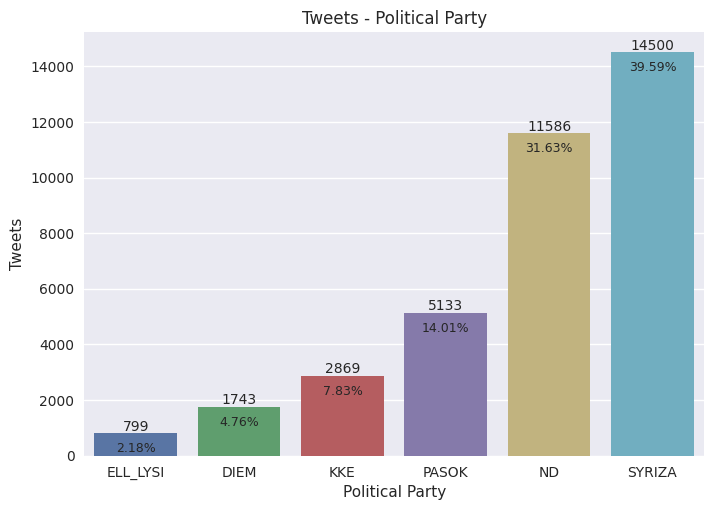

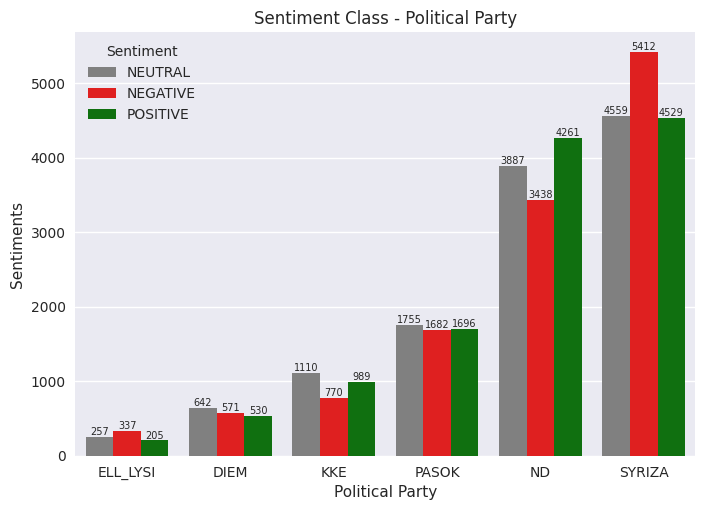

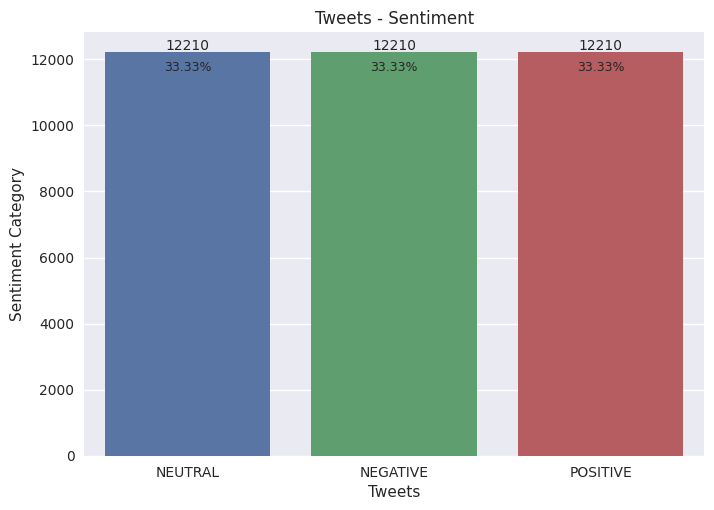

In [8]:
# Get the unique values for party
unique_values = df_train["Party"].unique()
# Find for each unique value their occurence
occurences = df_train["Party"].value_counts()[unique_values]
# Make a countplot
countplot(df_train["Party"], ["Political Party","Tweets"], True, False, True, "Tweets - Political Party")
try:
    plt.savefig('explore/tweets_pp.png')    
except:
    !mkdir explore
    plt.savefig('explore/tweets_pp.png')    
plt.show()
# Make the stacked countplot
stackedcountplot(df_train, ["Political Party","Sentiments"], "Party", "Sentiment", False, True, "Sentiment Class - Political Party")
try:
    plt.savefig('explore/sentiment_pp.png')    
except:
    !mkdir explore
    plt.savefig('explore/sentiment_pp.png')
plt.show()
# Get the unique values for sentiment
unique_values = df_train["Sentiment"].unique()
# Find for each unique value their occurence
occurences = df_train["Sentiment"].value_counts()[unique_values]
countplot(df_train["Sentiment"], ["Tweets","Sentiment Category"], True, False, None, "Tweets - Sentiment")
try:
    plt.savefig('explore/t_s.png')    
except:
    !mkdir explore
    plt.savefig('explore/t_s.png')  
plt.show()

Having thoroughly examined the dataset, we can now draw the following conclusions:
* The dataset is evenly distributed in terms of sentiment categories: </br></br>
&nbsp;&nbsp;12210 are NATURAL</br>
&nbsp;&nbsp;12210 are NEGATIVE</br>
&nbsp;&nbsp;12210 are POSITIVE</br></br>
* 39.59% of the tweets are reffering to "SYRIZA" in which:</br></br>
&nbsp;&nbsp;4559 are NATURAL</br>
&nbsp;&nbsp;5412 are NEGATIVE</br>
&nbsp;&nbsp;4529 are POSITIVE</br></br>
* 31.63% of the tweets are reffering to "ND" from which:</br></br>
&nbsp;&nbsp;3887 are NATURAL</br>
&nbsp;&nbsp;3438 are NEGATIVE</br>
&nbsp;&nbsp;4261 are POSITIVE</br></br>
* 14.01% of the tweets are reffering to "PASOK" from which:</br></br>
&nbsp;&nbsp;1755 are NATURAL</br>
&nbsp;&nbsp;1682 are NEGATIVE</br>
&nbsp;&nbsp;1696 are POSITIVE</br></br>
*  7.83% of the tweets are reffering to "KKE" from which:</br></br>
&nbsp;&nbsp;1110 are NATURAL</br>
&nbsp;&nbsp;770 are NEGATIVE</br> 
&nbsp;&nbsp;989 are POSITIVE</br></br>
*  4.76% of the tweets are reffering to "DIEM" from which:</br></br>
&nbsp;&nbsp;642 are NATURAL</br>
&nbsp;&nbsp;571 are NEGATIVE</br>
&nbsp;&nbsp;530 are POSITIVE</br></br>
*  2.18% of the tweets are reffering to "ELL_LYSI" from which:</br></br>
&nbsp;&nbsp;257 are NATURAL</br>
&nbsp;&nbsp;337 are NEGATIVE</br>
&nbsp;&nbsp;205 are POSITIVE

### We could also examine the validation set but we already know that it is the same as train set. On the other hand,  the test set does not containt the sentiment column, that's because the main purpose of this notebook is to predict their sentiment class using the train & validation sets.

# Data Pre-processing
In the previous assignment I conducted experiments with 3 different variations of the training set:
* No Pre-processing at all
* Basic Pre-processing
* Basic Pre-processing & Lemmatization<br>

While we are pre-processing the data we are creating a new column named `Tokens` in which we are storing the tokens of each tweet in order to use them in [Word2Vec](#word2vec) section.

## Data cleaning
The "winning" option proved to be the **Basic Pre-processing** so I'm going to do the same process below. After that I'm going to train my own Word2Vec model.

In [9]:
def remove_accents(word):
    ret =''.join(c for c in unicodedata.normalize('NFD', word) if unicodedata.category(c) != 'Mn')
    return ret

def clean_tweets(df, lemm):
    # That's the basic pre-processing    
    # Remove possible links starting with http/https/www
    df['Text'] = df['Text'].str.replace(r"(http[s]?://|www\.)[^\s]+", " ", regex = True)
    # Remove whole word with # symbol
    df['Text'] = df['Text'].str.replace(r"(#)[^\s]+", " ", regex = True)
    # Remove whole word with @ symbol
    df['Text'] = df['Text'].str.replace(r"(@)[^\s]+", " ", regex = True)
    # Lowercase everything
    df['Text'] = df['Text'].str.lower()
    # Keep only latin/greek letters and numbers
    df['Text'] = df['Text'].str.replace(r"[^\wa-zα-ω]", " ", regex = True)    
    # If the user wants to do the lemmazation process we will perform it otherwise the token will be added only if it is not a stop word
    df['Tokens'] = df['Text'].apply(lambda text: [token.lemma_ if lemm else token.text for token in nlp(remove_accents(text)) if token.text not in nlp.Defaults.stop_words and token.text.strip()])
    # At last we are combine the tokens to create the new text for the tweet    
    df['Text'] = df['Tokens'].apply(lambda tokens: " ".join(tokens))
    # Then return the cleaned dataframe
    return df

I'm adding two more stop words in the set and also remove the accents from the stop words.

In [10]:
for word in set(nlp.Defaults.stop_words):
    nlp.Defaults.stop_words.add(remove_accents(word))
nlp.Defaults.stop_words.add('κ')
nlp.Defaults.stop_words.add('κι')

#### The cell below has to run only one time in order for the pre-process to take place. After that we can just load the cleaned dataset that was mentioned above.

In [11]:
# First wabse copy the dataframe
df_train_cleaned_bp = df_train.copy()
# Now we will clean the text column
df_train_cleaned_bp = clean_tweets(df_train_cleaned_bp, False)
# Save the cleaned dataset in case we need it in the future instead of cleaning it from the beginning
df_train_cleaned_bp.to_json(OUTPUT_PATH + 'cleaned_train_bp.json')
# Now we are doing the same process for the validation set
df_val_cleaned_bp = df_val.copy()
df_val_cleaned_bp = clean_tweets(df_val_cleaned_bp, False)
df_val_cleaned_bp.to_json(OUTPUT_PATH + 'cleaned_val_bp.json')

## Loading cleaned dataset
We are loading the cleaned dataset.

In [12]:
#Load the cleaned data for Basic Pre-Processing
df_train_bp = pd.read_json(OUTPUT_PATH + "cleaned_train_bp.json")
df_val_bp = pd.read_json(OUTPUT_PATH + "cleaned_val_bp.json")

## Word2Vec
Now we are going to create and train our own Word2Vec model. I choosed to do that for two reasons:
1. To experiment and learn new techniques 
2. After thorough search I didn't come up with something I though it would be useful to me

The model was trained using the following:
* The Token column which we created during pre-processing phase was used as the input
* Each word in order to be known needs to have at least one 1 occurrence
* The dimension of each word vector is 300 
* In order to reproduce the results I'm also using a stable seed 212 (the last 3 digits of my sdi)
* 20 epochs was used to train the model

In [13]:
# Define the word2vec model
word2vec_model = Word2Vec(sentences=list(df_train_bp["Tokens"]), workers=1, min_count=1, vector_size=300, seed=212)

# Train the word2vec model as we said above
word2vec_model.train(list(df_train_bp["Tokens"]), epochs=20, total_examples=word2vec_model.corpus_count)

(6985904, 7411700)

### Mean Vector
The function below will return the mean vector for the given tweet. In this step, we are also taking advantage of the tokenization we had done in the Pre-Processing phase.

In [14]:
def mean_vector(tokens, model):
    # We still check for empty tweet just in case
    if not tokens:
        # Then the result is a numpy array with 300 elements 0
        return np.zeros(300)
    # Otherwise the model will find the mean vector and return it
    return model.wv.get_mean_vector(keys=list(tokens), weights=None, pre_normalize=False, post_normalize=False, ignore_missing=True)

In [15]:
# Make a new column with the mean vector for each tweet for the training set
df_train_bp["embeddings_mean_vector"] = df_train_bp["Tokens"].apply(mean_vector, model=word2vec_model)

# Save the new train dataset
df_train_bp.to_json(OUTPUT_PATH + 'cleaned_train_bp.json')

# Make a new column with the mean vector for each tweet for the validation set
df_val_bp["embeddings_mean_vector"] = df_val_bp["Tokens"].apply(mean_vector, model=word2vec_model)

# Save the new train dataset
df_val_bp.to_json(OUTPUT_PATH + 'cleaned_val_bp.json')

## Loading final dataset
We are loading the cleaned dataset with word embeddings.

In [16]:
#Load the cleaned data for Basic Pre-Processing
df_train_bp = pd.read_json(OUTPUT_PATH + "cleaned_train_bp.json")
df_val_bp = pd.read_json(OUTPUT_PATH + "cleaned_val_bp.json")

In [17]:
df_train_bp

,New_ID,Text,Sentiment,Party,Tokens,embeddings_mean_vector
0,35027,κυριακη κοριοι απολυμανση καταπολεμηση κοριων απεντομωση κοριους,NEUTRAL,SYRIZA,"[κυριακη, κοριοι, απολυμανση, καταπολεμηση, κοριων, απεντομωση, κοριους]","[-0.320455879, -0.2930819988, -0.2038263828, 0.0943768173, 0.2047514617, -0.2385916412, -0.12452..."
1,9531,νεες επιστολες μακεδονια καινε νδ μητσοτακης γνωριζε διχασε εθνος,NEGATIVE,ND,"[νεες, επιστολες, μακεδονια, καινε, νδ, μητσοτακης, γνωριζε, διχασε, εθνος]","[-0.2310140729, -0.7850291729000001, 0.22758072610000002, 0.546859324, -0.226630345, -0.45371198..."
2,14146,ισχυρο κκε δυναμη λαου βουλη καθημερινους αγωνες,POSITIVE,KKE,"[ισχυρο, κκε, δυναμη, λαου, βουλη, καθημερινους, αγωνες]","[-0.4481310248, 0.9097661972000001, 0.2006858289, 0.012127212200000001, -0.6237555146, -0.091245..."
3,28716,μνημονιακοτατο,NEUTRAL,KKE,[μνημονιακοτατο],"[-0.0010097063, -0.0009839003000000001, 0.001484412, 0.00292768, 0.0013669952, -0.0021932323, -0..."
4,32886,συγκλονιστικο ψυχασθενεια τσιπρα,NEUTRAL,SYRIZA,"[συγκλονιστικο, ψυχασθενεια, τσιπρα]","[0.005385431, 0.1798429489, -0.08814040570000001, 0.0298684929, 0.3525042534, -0.6981330514, -0...."
...,...,...,...,...,...,...
36625,35374,κουλης μητσοτακης λεει ψεματα αδειασε μπαμπη παπαδημητριου μπαμπης προετοιμαζει ερχεται κουλη μη...,NEUTRAL,ND,"[κουλης, μητσοτακης, λεει, ψεματα, αδειασε, μπαμπη, παπαδημητριου, μπαμπης, προετοιμαζει, ερχετα...","[-0.11106786880000001, -0.25184589620000003, 0.2801882327, 0.4194995761, -0.1625441313, -0.78706..."
36626,7744,προσεξε σκισει καλσον χαλια νεα φωτογραφια ομορφη πραγματικοτητα,NEGATIVE,ND,"[προσεξε, σκισει, καλσον, χαλια, νεα, φωτογραφια, ομορφη, πραγματικοτητα]","[-0.056676995, -0.0801754147, -0.1312818974, 0.23557062450000002, 0.0784835368, -0.3727927804, -..."
36627,35216,θεση κκε ασφαλεια πολιτων διαφορους ρουβικωνες βαθια κριση καπιταλιστικου συστηματος μειωση φορο...,NEUTRAL,KKE,"[θεση, κκε, ασφαλεια, πολιτων, διαφορους, ρουβικωνες, βαθια, κριση, καπιταλιστικου, συστηματος, ...","[-0.1677654535, 0.0407825969, -0.0971937105, -0.10770253090000001, -0.25494304300000004, -0.0043..."
36628,2855,μαρη κακομοιρα θυγατερα ναζιστη αντισημιτη ξεφτιλιστει τρολ νδ σχολιαζουν ντροπη μπορεις λιποθυμ...,NEGATIVE,ND,"[μαρη, κακομοιρα, θυγατερα, ναζιστη, αντισημιτη, ξεφτιλιστει, τρολ, νδ, σχολιαζουν, ντροπη, μπορ...","[-0.10858548430000001, -0.13995933530000002, 0.059420499999999994, 0.0475638211, -0.151209950400..."


# Neural Network
Below I will create an all in one class for the RNNs. Depending on the parameters we will give, a different neural network will be created.

The `GenericNeuralNetwork` consists of the following:
* Input Layer
* Hidden Size
* Output Layer
* Stacked Layers
* Dropout ratios
* Skip connections
* [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) as part of the 20% bonus


In [18]:
def Attention_Is_All_I_Ever_Wanted(HiddenSize, Input):
    Q_Layer = nn.Linear(HiddenSize * 2,HiddenSize * 2, bias = False, device = "cuda")
    K_Layer = nn.Linear(HiddenSize * 2,HiddenSize * 2, bias = False, device = "cuda")
    V_Layer = nn.Linear(HiddenSize * 2,HiddenSize * 2, bias = False, device = "cuda")
    MultiHead_Attention = nn.MultiheadAttention(HiddenSize * 2, num_heads = 1 ,batch_first = True, device = "cuda")
    return MultiHead_Attention(Q_Layer(Input), K_Layer(Input), V_Layer(Input))[0]

In [19]:
class GenericNeuralNetwork(nn.Module):
    def __init__(self, Cell, Input, HiddenSize, Output, StackedLayers, Dropout, Skip, Attention):
        super(GenericNeuralNetwork, self).__init__()
        cells = {"LSTM": nn.LSTM, "GRU": nn.GRU}
        self.cell = Cell
        self.hidden_size = HiddenSize
        self.stacked_layers = StackedLayers
        self.skip = Skip
        self.attention = Attention
    
        self.model = nn.ModuleList()
        for i in range(StackedLayers):
            self.model.append(cells[Cell](input_size = Input if i == 0 else HiddenSize * 2, hidden_size = HiddenSize, num_layers = 1, bidirectional = True, batch_first = True))
        
        self.dropout = nn.Dropout(Dropout)
        self.fc = nn.Linear(HiddenSize * 2, Output)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        for i, layer in enumerate(self.model):
            if self.cell == 'LSTM':
                r_out, (h_n, h_c) = layer(x if i == 0 else r_out) 
            else:
                r_out, h_n = layer(x if i == 0 else r_out)
            prev = r_out if i > 0 else None
            if i > 0:
                r_out = self.dropout(r_out)
            if self.skip and i > 0:
                r_out = r_out + prev
                
        if self.attention:
            r_out = r_out + Attention_Is_All_I_Ever_Wanted(self.hidden_size, r_out)
        return self.sigmoid(self.fc(r_out))

## Create DataLoader
Because we are building neural networks our data need a special represenation. The function below will convert the given dataset into a TensorDataset and then it will return the DataLoader for that dataset.

In [20]:
# This function will make a TensorDataset which I will use later on as the set in DataLoader
def create_dataloader(data, labels, labels_map, batch_size, shuffle):
    # We first need to convert the data from a Panda Series into a numpy array
    data = np.array(data.to_list())

    # We also need to convert the labels from a Panda Series into a numpy array
    labels = np.array(labels.to_list())
    
    # Mapping the labels based on the dictionary provided as the 3rd argument
    mapped_labels = np.array([labels_map[label] for label in labels])
        
    # Convert data to fit the requirements
    data = torch.from_numpy(data).type(torch.float)
    
    # Convert labels to fit the requirements
    mapped_labels = torch.from_numpy(mapped_labels)

    # Store the TensorData
    data_set = TensorDataset(data, mapped_labels)
    
    # Return the DataLoader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)

## Train, Test & Evaluate our model

### Show Report
The `show_report` function is responsible for displaying the results.

In [21]:
def show_report(t, loss, f, a, r, p):
    print(f"Time Taken:   \t\t{t:.3f}")
    print(f"Average Loss: \t\t{loss}")
    print(f"F1-Score:     \t\t{f}")
    print(f"Accuracy:     \t\t{a}")
    print(f"Recall:       \t\t{r}")
    print(f"Precision:    \t\t{p}")

### Testing Process
The `testing_process` makes all the nececary calculations in order to evaluate our model

In [22]:
def testing_process(model, dataloader, costFunc, device):
    preds = []
    
    targets = []
    
    model.eval()
    
    sum_losses = 0.0
    
    with torch.no_grad():
        for X, y in dataloader:
            
            # Move the data to the corresponding device
            X = X.to(device)
            y = y.to(device)
  
            # Compute prediction and loss
            pred = model(X.float())
            loss = costFunc(pred, y)
            sum_losses += loss.item()
    
            preds.append(pred)
            targets.append(y)

    loss = sum_losses / len(dataloader)
    f = F1Score(task='multiclass', average="weighted", num_classes=3).to(device)
    a = Accuracy(task='multiclass', average="weighted", num_classes=3).to(device)
    r = Recall(task='multiclass', average="weighted", num_classes=3).to(device)
    p = Precision(task='multiclass', average="weighted", num_classes=3).to(device)
    
    f = f(torch.cat(preds), torch.cat(targets)).item()
    a = a(torch.cat(preds), torch.cat(targets)).item()
    r = r(torch.cat(preds), torch.cat(targets)).item()
    p = p(torch.cat(preds), torch.cat(targets)).item()
    
    return loss, f, a, r, p, preds, targets

### Epoch Process
The `epoch_process` function was made in order for us to train our model in each epoch

In [23]:
def epoch_process(epochs, epoch, model, dataloader, optimizer, costFunc, size, scheduler, clip, device, show_progress):
    model.train()
    
    if show_progress:
        print(f"Epoch {epoch+1:{len(str(epochs))}d}\n-----------------------------")
    
    for batch, (X, y) in enumerate(dataloader):
        # Move the data to the corresponding device
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        loss = costFunc(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        # Per 750 batches for each epoch display the loss
        if show_progress and batch % 750 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>8f}  [{current:>{len(str(size))}d}/{size:>{len(str(size))}d}]")
            
    if scheduler:
        scheduler.step()
        
    if show_progress:
        print()

### Training Process
The `training_process` function is liable for the whole training process.

In [24]:
def training_process(epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, scheduler, clip, device, show_progress):
    
    train_losses, train_f1 = [], []
    
    val_losses, val_f1 = [], []
    
    size = len(train_dataloader.dataset)
    
    best_stats = {"max_f1": -1, "best_model": None, "epoch": None }
    
    for epoch in range(epochs):
    
        epoch_process(epochs, epoch, model, train_dataloader, optimizer, costFunc, size, scheduler, clip, device, show_progress)

        curr_mean_train_loss, f1_train, _, _, _, _, _ = testing_process(model, train_dataloader, costFunc, device)
        train_losses.append(curr_mean_train_loss)
        train_f1.append(f1_train)
    
        curr_mean_val_loss, f1_val, _, _, _, _, _ = testing_process(model, val_dataloader, costFunc, device)
        val_losses.append(curr_mean_val_loss)
        val_f1.append(f1_val)
            
        if f1_val > best_stats["max_f1"]:
            best_stats["max_f1"] = f1_val
            best_stats["best_model"] = model
            best_stats["epoch"] = epoch + 1
        
    return model, train_losses, val_losses, train_f1, val_f1, best_stats

### Evaluation Process
The `evaluation_process` is the core of our notebook, it trains our model & testing our model and plot the necessary curves

In [25]:
def evaluation_process(path, train_dataloader, val_dataloader, model, epochs, optimizer, costFunc, learning_rate, scheduler, scheduler_info, clip, device, show_progress):
    model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr = learning_rate)
    
    if scheduler:
        scheduler = scheduler(optimizer, lr = learning_rate, **scheduler_info)
    
    # Begin timer    
    begin_timer = time.perf_counter()
    
    # Do the train
    trained_model, train_losses, val_losses, train_f1, val_f1, best_stats = training_process(epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, scheduler, clip, device, show_progress)

    # Stop timer
    stop_timer = time.perf_counter()

    # Train class report  
    loss_train, f_train, a_train, r_train, p_train, preds_train, targets_train = testing_process(best_stats["best_model"], train_dataloader, costFunc, device)
    
    # Val class report  
    loss_val, f_val, a_val, r_val, p_val, preds_val, targets_val = testing_process(best_stats["best_model"], val_dataloader, costFunc, device)
    
    train_class_report = classification_report( y_true = torch.cat(targets_train).cpu().numpy(), 
                                                y_pred = list(np.concatenate([(torch.max(i, 1)[1].tolist()) for i in preds_train])), 
                                                target_names=["NEGATIVE", "NEUTRAL", "POSITIVE"])
    
    val_class_report= classification_report( y_true = torch.cat(targets_val).cpu().numpy(), 
                                             y_pred = list(np.concatenate([(torch.max(i, 1)[1].tolist()) for i in preds_val])), 
                                             target_names=["NEGATIVE", "NEUTRAL", "POSITIVE"])
    
    train_class_report = list("Training classification report                  \n\n") + list(train_class_report)
    val_class_report = list("Validation classification report\n\n") + list(val_class_report)
    
    show_report(stop_timer - begin_timer, loss_val, f_val, a_val, r_val, p_val)
    
    print()
    
    for i,j in zip(''.join(train_class_report).split("\n"), ''.join(val_class_report).split("\n")):
        print(f"{i}\t\t{j}")
    
    # That's just to save the plots in order for us to download them and use them in report instead of screenshooting everything
    fig = plt.figure()
    custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], "Epochs", "Loss", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_loss.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_loss.png')  
    
    fig = plt.figure()
    custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], "Epochs", "F1-Score", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_f1.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_f1.png')      
    
    
    # Display plots       
    all_plots = [ "custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], \"Epochs\", \"Loss\", False)",
                  "custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], \"Epochs\", \"F1-Score\", False)"]
    # Make subplots
    _, axes = plt.subplots(1, len(all_plots), figsize=(15, 5))
    # Print each plot in a different subplot section
    for i, plot_command in enumerate(all_plots):
        plt.subplot(1, len(all_plots), i + 1)
        exec(f"{plot_command}")
    plt.tight_layout()
#     plt.savefig(f"{path}/combined.png")
    plt.show()

In [26]:
# Map each category to it's corresponding integer
labels_to_ints = {np.unique(df_train_bp["Sentiment"])[i]: i for i in range(0, len(np.unique(df_train_bp["Sentiment"])))}

# Create DataLoader for the train set
train_dataloader = create_dataloader(df_train_bp["embeddings_mean_vector"], df_train_bp["Sentiment"], labels_to_ints, 16, True)

# Create DataLoader for the val set
val_dataloader = create_dataloader(df_val_bp["embeddings_mean_vector"], df_val_bp["Sentiment"], labels_to_ints, 16, False)

# Algorithms and Experiments

For the experiments, I used the Adam optimizer and the Cross-Entropy loss function as I was told to. For the development of the model, I utilized the experiment based on the following parameters:
* the number of stacked RNNs
* the number of hidden layers
* type of cells
* skip connections
* gradient clipping
* dropout probability
* number of epochs
* learning rates
* attention

In [27]:
def objective(trial):
    Cell          = trial.suggest_categorical('Cell', ["LSTM", "GRU"])
    HiddenSize    = trial.suggest_categorical('Hidden Size', [16, 32, 64, 128, 256, 512])
    StackedLayers = trial.suggest_categorical('Stacked Layers', [2, 3, 4, 5])
    Dropout       = trial.suggest_float('Dropout', 0.0, 0.5)
    Skip          = trial.suggest_categorical('Skip', [True, False])
    Attention     = trial.suggest_categorical('Attention', [True, False])
    Clip          = trial.suggest_float('Clip', 0.2, 1.0)
    Epochs        = trial.suggest_categorical('Epochs', [5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    Lr            = trial.suggest_float('Learning Rate', 0.001, 0.01)
    
    device        = "cuda" if torch.cuda.is_available() else "cpu"
    optimizer     = torch.optim.Adam
    costFunc      = nn.CrossEntropyLoss() 
    
    # Eliminate randomness    
    randonmness_elimination(212)

    model = GenericNeuralNetwork(Cell, 300, HiddenSize, 3, StackedLayers, Dropout, Skip, Attention)
    
    model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr = Lr)
    
    # Do the train
    _, _, _, _, _, best_stats = training_process(Epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, None, Clip, device, False)
    
    # Val class report  
    _, f_val, _, _, _, _, _ = testing_process(best_stats["best_model"], val_dataloader, costFunc, device)
    
    return f_val

In [28]:
# I initialized the sampler with specific seed in order to get the same results every time
sampler = optuna.samplers.RandomSampler(seed=212)
study = optuna.create_study(direction = "maximize", sampler = sampler, study_name = "RNNs Study")
study.optimize(objective, n_trials = 48)
df_trials = study.trials_dataframe()
df_trials

[I 2024-02-10 00:11:18,669] A new study created in memory with name: RNNs Study
[I 2024-02-10 00:34:41,928] Trial 0 finished with value: 0.1666666716337204 and parameters: {'Cell': 'GRU', 'Hidden Size': 512, 'Stacked Layers': 3, 'Dropout': 0.017907510607577115, 'Skip': True, 'Attention': True, 'Clip': 0.21730551026764255, 'Epochs': 45, 'Learning Rate': 0.007281628166012959}. Best is trial 0 with value: 0.1666666716337204.
[I 2024-02-10 00:36:20,902] Trial 1 finished with value: 0.1666666716337204 and parameters: {'Cell': 'GRU', 'Hidden Size': 16, 'Stacked Layers': 5, 'Dropout': 0.3895274627103108, 'Skip': True, 'Attention': False, 'Clip': 0.5537943257705902, 'Epochs': 5, 'Learning Rate': 0.004872207041068744}. Best is trial 0 with value: 0.1666666716337204.
[I 2024-02-10 00:40:34,175] Trial 2 finished with value: 0.1666666716337204 and parameters: {'Cell': 'LSTM', 'Hidden Size': 32, 'Stacked Layers': 4, 'Dropout': 0.496119704829995, 'Skip': False, 'Attention': False, 'Clip': 0.78550048

,number,value,datetime_start,datetime_complete,duration,params_Attention,params_Cell,params_Clip,params_Dropout,params_Epochs,params_Hidden Size,params_Learning Rate,params_Skip,params_Stacked Layers,state
0,0,0.166667,2024-02-10 00:11:18.670351,2024-02-10 00:34:41.927753,0 days 00:23:23.257402,True,GRU,0.217306,0.017908,45,512,0.007282,True,3,COMPLETE
1,1,0.166667,2024-02-10 00:34:41.929604,2024-02-10 00:36:20.902020,0 days 00:01:38.972416,False,GRU,0.553794,0.389527,5,16,0.004872,True,5,COMPLETE
2,2,0.166667,2024-02-10 00:36:20.903806,2024-02-10 00:40:34.174837,0 days 00:04:13.271031,False,LSTM,0.785500,0.496120,15,32,0.008370,False,4,COMPLETE
3,3,0.166667,2024-02-10 00:40:34.176484,2024-02-10 00:43:12.998464,0 days 00:02:38.821980,False,LSTM,0.952720,0.480285,5,256,0.007313,False,5,COMPLETE
4,4,0.166667,2024-02-10 00:43:13.000086,2024-02-10 00:51:30.739262,0 days 00:08:17.739176,False,GRU,0.795156,0.219839,25,64,0.003309,True,5,COMPLETE
5,5,0.166667,2024-02-10 00:51:30.741056,2024-02-10 00:55:39.770020,0 days 00:04:09.028964,True,GRU,0.690678,0.063369,10,512,0.009749,False,2,COMPLETE
6,6,0.166667,2024-02-10 00:55:39.771858,2024-02-10 01:01:52.118848,0 days 00:06:12.346990,True,GRU,0.631030,0.035585,15,512,0.009802,False,2,COMPLETE
7,7,0.166667,2024-02-10 01:01:52.121257,2024-02-10 01:07:57.225131,0 days 00:06:05.103874,True,GRU,0.787333,0.194186,20,128,0.005475,False,2,COMPLETE
8,8,0.345032,2024-02-10 01:07:57.226897,2024-02-10 01:27:50.290043,0 days 00:19:53.063146,True,GRU,0.637449,0.299103,50,16,0.001655,True,4,COMPLETE
9,9,0.166667,2024-02-10 01:27:50.291858,2024-02-10 01:34:32.831534,0 days 00:06:42.539676,False,GRU,0.485005,0.326352,20,256,0.001869,True,3,COMPLETE


In [29]:
plot_edf(study)

In [30]:
plot_optimization_history(study)

In [31]:
plot_parallel_coordinate(study)

In [32]:
plot_param_importances(study)

In [33]:
plot_slice(study)

# Best Model

## Architecture of Best RNN

In [34]:
print("The architecture of the best RNN, according to optuna, is:")

print('Cell:           LSTM')
print('Hidden Size:    64')
print('Stacked Layers: 2')
print('Dropout:        0.45394892557886596')
print('Skip:           True')
print('Attention:      True')
print('Clip:           0.40404745697248434')
print('Epochs:         15')
print('Learning Rate:  0.002752755011361541')

The architecture of the best RNN, according to optuna, is:
Cell:           LSTM
Hidden Size:    64
Stacked Layers: 2
Dropout:        0.45394892557886596
Skip:           True
Attention:      True
Clip:           0.40404745697248434
Epochs:         15
Learning Rate:  0.002752755011361541


## Checking for Over/Under-fitting

Time Taken:   		265.754
Average Loss: 		1.086568683841542
F1-Score:     		0.38787487149238586
Accuracy:     		0.3899082839488983
Recall:       		0.3899082839488983
Precision:    		0.3897986114025116

Training classification report                  		Validation classification report
		
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
    NEGATIVE       0.44      0.52      0.47     12210		    NEGATIVE       0.39      0.46      0.42      1744
     NEUTRAL       0.47      0.40      0.43     12210		     NEUTRAL       0.39      0.32      0.35      1744
    POSITIVE       0.47      0.45      0.46     12210		    POSITIVE       0.39      0.38      0.39      1744
		
    accuracy                           0.46     36630		    accuracy                           0.39      5232
   macro avg       0.46      0.46      0.46     36630		   macro avg       0.39      0.39      0.39      5232
weighted avg       0.46      0.46      0.46     36630	

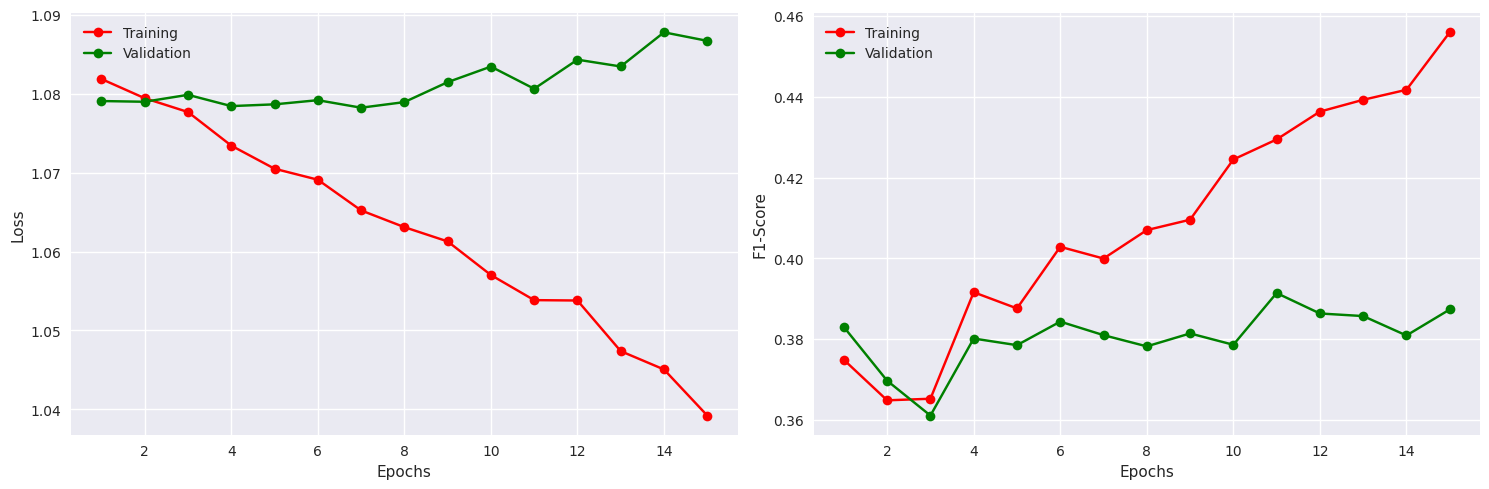

In [35]:
# Eliminate randomness    
randonmness_elimination(212)

model = GenericNeuralNetwork("LSTM", 300, 64, 3, 2, 0.45394892557886596, True, True)

evaluation_process( path = f"best_test_opt",
                    train_dataloader = train_dataloader, 
                    val_dataloader = val_dataloader, 
                    model = model,
                    epochs = 15, 
                    optimizer = torch.optim.Adam, 
                    costFunc = nn.CrossEntropyLoss(), 
                    learning_rate = 0.002752755011361541,  
                    scheduler = None,
                    scheduler_info = None,
                    clip = 0.40404745697248434,
                    device = "cuda" if torch.cuda.is_available() else "cpu",  
                    show_progress = False)

### It's clear from both loss & f1 curves that the model is overfitting
</br>
</br>
</br>

## Through a series of experiments which I'm not able to present here due to time limit in GPU usage </br>I end up with the model below as the best option

In [36]:
print("The architecture of the best RNN:")

print('Cell:           LSTM')
print('Hidden Size:    64')
print('Stacked Layers: 3')
print('Dropout:        0')
print('Skip:           True')
print('Attention:      True')
print('Clip:           0')
print('Epochs:         6')
print('Learning Rate:  0.002752755011361541')

The architecture of the best RNN:
Cell:           LSTM
Hidden Size:    64
Stacked Layers: 3
Dropout:        0
Skip:           True
Attention:      True
Clip:           0
Epochs:         6
Learning Rate:  0.002752755011361541


Time Taken:   		116.333
Average Loss: 		1.0772073864936829
F1-Score:     		0.39832600951194763
Accuracy:     		0.4073012173175812
Recall:       		0.4073012173175812
Precision:    		0.4108690619468689

Training classification report                  		Validation classification report
		
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
    NEGATIVE       0.39      0.57      0.46     12210		    NEGATIVE       0.40      0.59      0.47      1744
     NEUTRAL       0.40      0.31      0.35     12210		     NEUTRAL       0.40      0.31      0.35      1744
    POSITIVE       0.43      0.32      0.37     12210		    POSITIVE       0.43      0.32      0.37      1744
		
    accuracy                           0.40     36630		    accuracy                           0.41      5232
   macro avg       0.41      0.40      0.39     36630		   macro avg       0.41      0.41      0.40      5232
weighted avg       0.41      0.40      0.39     36630

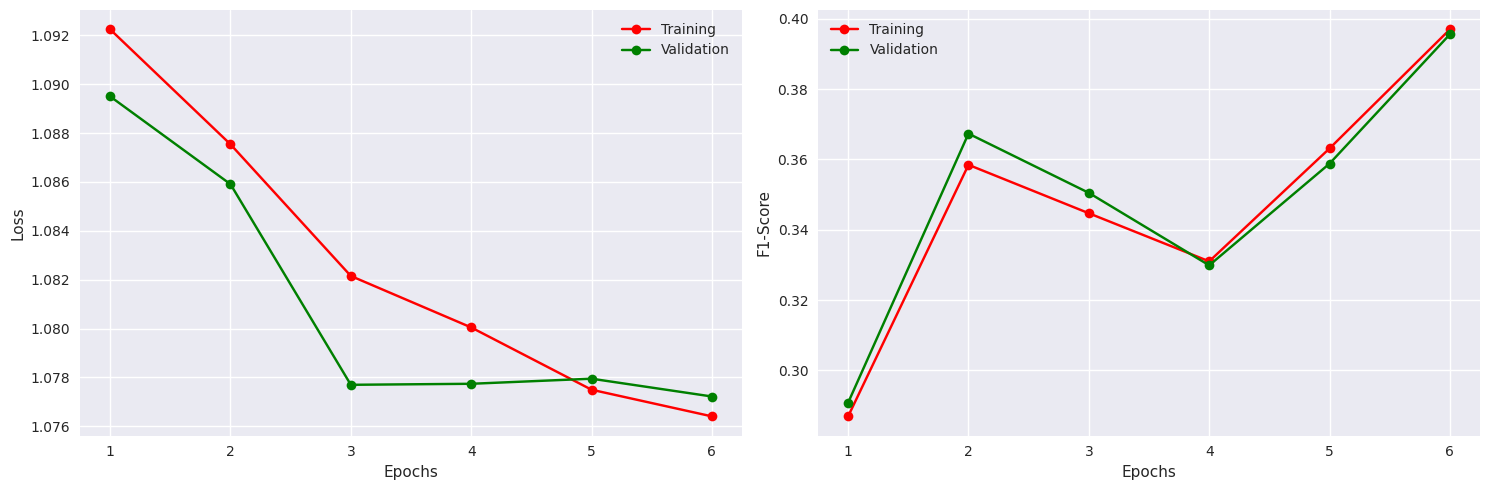

In [37]:
# Eliminate randomness    
randonmness_elimination(212)

model = GenericNeuralNetwork("LSTM", 300, 64, 3, 3, 0, True, True)

evaluation_process( path = f"best_test_mine",
                    train_dataloader = train_dataloader, 
                    val_dataloader = val_dataloader, 
                    model = model,
                    epochs = 6, 
                    optimizer = torch.optim.Adam, 
                    costFunc = nn.CrossEntropyLoss(), 
                    learning_rate = 0.002752755011361541,  
                    scheduler = None,
                    scheduler_info = None,
                    clip = 0,
                    device = "cuda" if torch.cuda.is_available() else "cpu",  
                    show_progress = False)

## Extract all informations about the best model

In [38]:
def evaluation_process_best(path, train_dataloader, val_dataloader, model, epochs, optimizer, costFunc, learning_rate, scheduler, scheduler_info, clip, device, show_progress):
    model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr = learning_rate)
    
    if scheduler:
        scheduler = scheduler(optimizer, lr = learning_rate, **scheduler_info)
    
    # Begin timer    
    begin_timer = time.perf_counter()
    
    # Do the train
    trained_model, train_losses, val_losses, train_f1, val_f1, best_stats = training_process(epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, scheduler, clip, device, show_progress)

    # Stop timer
    stop_timer = time.perf_counter()
    
    loss_val, f_val, a_val, r_val, p_val, preds_val, targets_val = testing_process(best_stats["best_model"], val_dataloader, costFunc, device)
       
    show_report(stop_timer - begin_timer, loss_val, f_val, a_val, r_val, p_val)
    
    print()
    
    # That's just to save the plots in order for us to download them and use them in report instead of screenshooting everything
    fig = plt.figure()
    custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], "Epochs", "Loss", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_loss.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_loss.png')  
    
    fig = plt.figure()
    custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], "Epochs", "F1-Score", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_f1.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_f1.png')      
    
    # ROC Curve
    fig = plt.figure()
    custom_roc_curve(torch.cat(targets_val).cpu().numpy(), torch.cat(preds_val).cpu().numpy(), False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/roc.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/roc.png')

    # Confusion Matrix
    fig = plt.figure()
    conf_matrix = ConfusionMatrix(task='multiclass', num_classes=3, normalize='true').cpu()
    custom_confusion_matrix(conf_matrix(torch.cat(preds_val).cpu(), torch.cat(targets_val).cpu()).numpy(), False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/cm.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/cm.png')
    
    
    # Display plots       
    all_plots = [ "custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], \"Epochs\", \"Loss\", False)",
                  "custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], \"Epochs\", \"F1-Score\", False)",
                  "custom_roc_curve(torch.cat(targets_val).cpu().numpy(), torch.cat(preds_val).cpu().numpy(), False)",
                  "custom_confusion_matrix(conf_matrix(torch.cat(preds_val).cpu(), torch.cat(targets_val).cpu()).numpy(), False)"
                ]
    # Make subplots
    _, axes = plt.subplots(1, len(all_plots), figsize=(20, 5))
    # Print each plot in a different subplot section
    for i, plot_command in enumerate(all_plots):
        plt.subplot(1, len(all_plots), i + 1)
        exec(f"{plot_command}")
    plt.tight_layout()
#     plt.savefig(f"{path}/combined.png")
    plt.show()
    

Time Taken:   		116.504
Average Loss: 		1.0774550789722244
F1-Score:     		0.39271280169487
Accuracy:     		0.40214067697525024
Recall:       		0.40214067697525024
Precision:    		0.40405863523483276



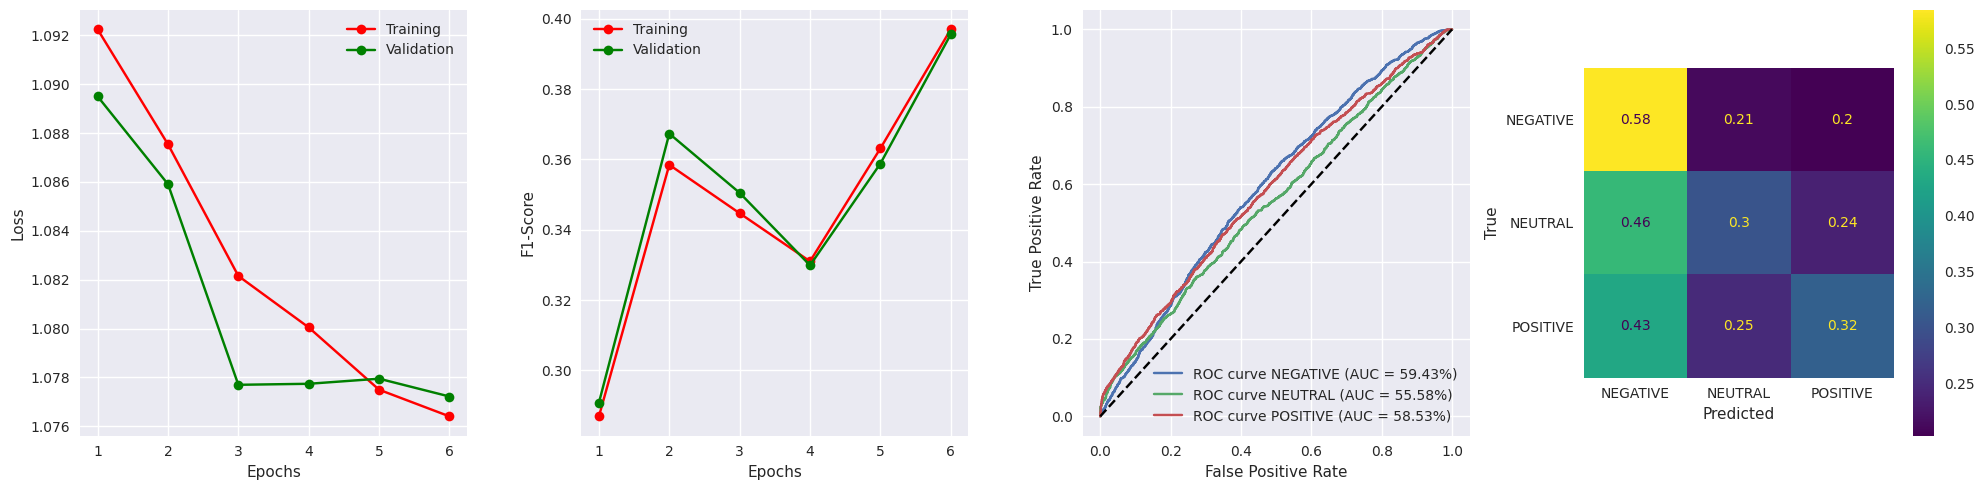

In [39]:
# Eliminate randomness    
randonmness_elimination(212)

model = GenericNeuralNetwork("LSTM", 300, 64, 3, 3, 0, True, True)

evaluation_process_best( path = f"best_model",
                         train_dataloader = train_dataloader, 
                         val_dataloader = val_dataloader, 
                         model = model,
                         epochs = 6, 
                         optimizer = torch.optim.Adam, 
                         costFunc = nn.CrossEntropyLoss(), 
                         learning_rate = 0.002752755011361541,  
                         scheduler = None,
                         scheduler_info = None,
                         clip = 0,
                         device = "cuda" if torch.cuda.is_available() else "cpu",  
                         show_progress = False)

In [40]:
# This cell was executed in order to take all the images with one download and categorized in their directory
!zip -r file.zip /kaggle/working -q

# Evaluation on Test Set
The function below will make evaluations for the test set. It needs the path to the train and the test. It makes the necessary pre-processing, it creates the previous model, which was found the most optimal among many, and make predictions for the test set in the submission.csv

In [41]:
def predict_unseen_data(TRAIN_PATH, TEST_PATH):
    # Eliminate randomness    
    randonmness_elimination(212)
    
    df_train = pd.read_csv(TRAIN_PATH)
    
    df_test = pd.read_csv(TEST_PATH)
    
    # First wabse copy the dataframe
    df_train_cleaned_bp = df_train.copy()
    # Now we will clean the text column
    df_train_cleaned_bp = clean_tweets(df_train_cleaned_bp, False)
    
    # Now we are doing the same process for the test set
    df_test_cleaned_bp = df_test.copy()
    df_test_cleaned_bp = clean_tweets(df_test_cleaned_bp, False)
    
    # Define the word2vec model
    word2vec_model = Word2Vec(sentences=list(df_train_cleaned_bp["Tokens"]), workers=1, min_count=1, vector_size=300, seed=212)

    # Train the word2vec model as we said above
    word2vec_model.train(list(df_train_cleaned_bp["Tokens"]), epochs=20, total_examples=word2vec_model.corpus_count)
    
    # Make a new column with the mean vector for each tweet for the training set
    df_train_cleaned_bp["embeddings_mean_vector"] = df_train_cleaned_bp["Tokens"].apply(mean_vector, model=word2vec_model)

    # Make a new column with the mean vector for each tweet for the validation set
    df_test_cleaned_bp["embeddings_mean_vector"] = df_test_cleaned_bp["Tokens"].apply(mean_vector, model=word2vec_model)

    
    # Make dataloader ONLY for train

    # Map each category to it's corresponding integer
    labels_to_ints = {np.unique(df_train_cleaned_bp["Sentiment"])[i]: i for i in range(0, len(np.unique(df_train_cleaned_bp["Sentiment"])))}

    # Create DataLoader for the train set
    train_dataloader = create_dataloader(df_train_cleaned_bp["embeddings_mean_vector"], df_train_cleaned_bp["Sentiment"], labels_to_ints, 16, True)

    # And the other way around in order to change the .csv
    ints_to_labels = {i: np.unique(df_train_cleaned_bp["Sentiment"])[i] for i in range(0, len(np.unique(df_train_cleaned_bp["Sentiment"])))}
    
    device = "cuda" if torch.cuda.is_available() else "cpu"  
    
    # For the test we are making only a torch
    # We first need to convert the data from a Panda Series into a numpy array
    TEST = np.array(df_test_cleaned_bp["embeddings_mean_vector"].to_list())
    # Convert data to fit the requirements
    TEST = torch.from_numpy(TEST).float().to(device)
    
    # Eliminate randomness    
    randonmness_elimination(212)
    
    model = GenericNeuralNetwork("LSTM", 300, 64, 3, 3, 0, True, True)
    
    model = model.to(device)
     
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.002752755011361541)    
    epochs = 6
    costFunc = nn.CrossEntropyLoss()
    clip = 0    
    
    for epoch in range(epochs):
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            # Move the data to the corresponding device
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            loss = costFunc(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            if clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

    model.eval()
    preds = model(TEST)

    final = [ints_to_labels[torch.argmax(i).item()] for i in preds]

    df_final = pd.DataFrame(list(enumerate(final, start=1)), columns=["Id", "Predicted"])
    df_final.to_csv(OUTPUT_PATH + "submission.csv", index=False)
    
    print("Sentiment Classification is done!")
    print("You can find the results in the submission.csv")

In [42]:
predict_unseen_data(INPUT_PATH + "train_set.csv", INPUT_PATH + "test_set.csv")

Sentiment Classification is done!
You can find the results in the submission.csv
